# Full Data Preprocessing Pipeline

Built using [feature-engine](https://feature-engine.readthedocs.io/en/latest/) and Scikit-Learn transformers

<br>
<br>

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, probplot
import seaborn as sns
plt.rcParams.update({'figure.max_open_warning': 0})


# for the model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from feature_engine import missing_data_imputers as mdi
from feature_engine import categorical_encoders as ce
from feature_engine.outlier_removers import Winsorizer
from feature_engine import variable_transformers as vt
from feature_engine.discretisers import EqualFrequencyDiscretiser

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin, clone

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

<br>
<br>

**Feature lists and Custom Transformers**

In [2]:
garage_categoric = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]
garage_numeric = ["GarageYrBlt", "GarageCars", "GarageArea"]
bsmt_categoric = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
bsmt_numeric = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtHalfBath", "BsmtFullBath"]
other_categoric = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "MasVnrType"]
other_numeric = ["MasVnrArea"]
mcar_categoric = ["Electrical", "MSZoning", "Functional", "Utilities", "SaleType", "KitchenQual", "Exterior1st", "Exterior2nd"]

feats_to_coerce = ["MSSubClass", "MoSold", "YrSold", "BsmtFullBath", "BsmtHalfBath", "GarageYrBlt"]

cat_ordinal_feats = ["Alley", "LandSlope", "LotShape", "LandContour", "BsmtFullBath", "BsmtHalfBath",
                 "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "KitchenAbvGr",
                 "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional",
                 "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC"]

cat_nominal_feats = ["HouseStyle", "MSZoning", "LotConfig", "Neighborhood", "Condition1", "GarageYrBlt",
                     "Condition2", "BldgType", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
                     "MasVnrType", "Foundation", "Heating", "CentralAir", "Electrical", "GarageType", "Fence",
                     "MiscFeature", "SaleType", "SaleCondition", "MSSubClass", "MoSold", "YrSold"]

discretise_feats = ["MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "LowQualFinSF", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"]

class DropColumns(BaseEstimator, TransformerMixin):

    def __init__(self, variables=[]):
        self.variables = variables
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        return X_copy.drop(columns=self.variables)
    
def rare_categories(df, num_levels=[0,2], print_percentage=False, plot=False):
    multi_cat_cols = []
    for col in df.columns:
        if df[col].dtypes =='object':
            if num_levels[0] <= df[col].nunique() <= num_levels[1]:
                multi_cat_cols.append(col)
                if print_percentage:
                    print(train_df.groupby(col)[col].count().sort_values(ascending=False) / len(train_df))
                    print()
    
    if plot:
        for col in multi_cat_cols:
            temp_df = pd.Series(df[col].value_counts() / len(df))
            fig = temp_df.sort_values(ascending=False).plot.bar()
            fig.set_xlabel(col)
            fig.axhline(y=0.05, color='red')
            fig.set_ylabel('Percentage of houses')
            plt.show()
            
    return multi_cat_cols

class ConvertDtype(BaseEstimator, TransformerMixin):
    def __init__(self, dtype=str, variables=[]):
        self.variables = variables
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy[self.variables] = X_copy[self.variables].astype(self.dtype)
        return X_copy

class DropQuasiConstant(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.998):
        self.threshold = threshold
    def fit(self, X, y=None):
        self.quasi_const_feats = []
        for feature in X.columns:
            # find the predominant value
            predominant = (X[feature].value_counts() / np.float(
                len(X))).sort_values(ascending=False).values[0]

            # evaluate predominant feature
            if predominant > self.threshold:
                self.quasi_const_feats.append(feature)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        return X_copy.drop(columns=self.quasi_const_feats)
    
class RareCategories(BaseEstimator, TransformerMixin):
    def __init__(self, num_levels=[3,100], tol=0.01, n_categories=4):
        self.num_levels = num_levels
        self.tol = tol
        self.n_categories = n_categories
    def fit(self, X, y=None):
        self.rare_cats = rare_categories(X, self.num_levels)
        self.encoder = ce.RareLabelCategoricalEncoder(
            tol=self.tol,
            n_categories=self.n_categories,
            variables=self.rare_cats
        )
        self.encoder.fit(X)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        return self.encoder.transform(X)
    
class DropPoints(BaseEstimator, TransformerMixin):
    def __init__(self, idx=[1298, 523, 30, 632, 812, 495]):
        self.idx = idx
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        return X_copy.drop(self.idx)
    
class GetFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        self.feat_names = list(X.columns)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        return X_copy

<br>
<br>

## Build data preprocessing pipeline

In [3]:
house_pipe = Pipeline([
    # Missing data
    ('mnar_cat_imp', mdi.CategoricalVariableImputer(
        variables=garage_categoric+bsmt_categoric+other_categoric)),
    ('mnar_num_imp', mdi.ArbitraryNumberImputer(
        arbitrary_number=0,
        variables=garage_numeric+bsmt_numeric+other_numeric)),
    ('mcar_cat_imp', mdi.FrequentCategoryImputer(
        variables=mcar_categoric)),
    ('lotfrontage_ind', mdi.AddNaNBinaryImputer(
        variables=["LotFrontage"])),
    ('lotfrontage_imp', mdi.RandomSampleImputer(
        random_state=20, 
        variables=["LotFrontage"])),

    # categorical encoding
    ('to_int', ConvertDtype(
        dtype=int,
        variables=feats_to_coerce)),
    ('to_str1', ConvertDtype(
        dtype=str,
        variables=cat_ordinal_feats+cat_nominal_feats)),
    ('drop_cols', DropColumns(
        variables=['Street', 'Utilities'])),
    ('rare_enc', RareCategories(
        num_levels=[3,100])),
    ('mean_enc', ce.MeanCategoricalEncoder(
        variables=cat_ordinal_feats)),
    ('ordered_int_enc', ce.OrdinalCategoricalEncoder(
        encoding_method='ordered', 
        variables=cat_nominal_feats)),
    
    # Feature transformation
    ('yj_transf', vt.YeoJohnsonTransformer(
        variables=["LotFrontage", "LotArea", "TotalBsmtSF", "1stFlrSF", "GrLivArea"])),
    ('discretise', EqualFrequencyDiscretiser(
        q=10, 
        variables=discretise_feats)),
    ('to_str', ConvertDtype(
        dtype=str,
        variables=discretise_feats)),
    ('mean_discr_enc', ce.MeanCategoricalEncoder(
        variables=discretise_feats)),
    
    # Drop Quasi-Constant features
    ('drop_quasi_const', DropQuasiConstant(
        threshold=0.998)),
    
    # Drop Correlated features
    ('drop_corr', DropColumns(
        variables=['Exterior2nd', 'GarageCars', 'GarageQual'])),
    
    # Drop Influential Points
    ('drop_infl', DropPoints(
        idx=[1298, 523, 30, 632, 812, 495]
    )),
    
    # Get final feature names
    ('feat_names', GetFeatNames()),
    
    # Perform scaling
    ('scaler', StandardScaler()),
    

])

<br>
<br>

## Apply data preprocessing pipeline

In [4]:
train_df = pd.read_csv("data/train.csv")
train_labels = train_df[["SalePrice"]].copy()
train_df.drop(columns=["Id", "SalePrice"], inplace=True)
test_df = pd.read_csv("data/test.csv")
test_id = test_df[["Id"]].copy()
test_df.drop(columns="Id", inplace=True)

# Fit the pipeline
X_train = house_pipe.fit_transform(train_df, train_labels)
X_test = house_pipe.transform(test_df)

# Drop influential points from labels
train_labels.drop(house_pipe.named_steps['drop_infl'].idx, inplace=True)
# Log transform response
train_labels['SalePrice'] = np.log(train_labels['SalePrice'])
y_train = train_labels.values

<br>
<br>

## Model Tuning/Feature Selection

**Lasso**

Best param: {'alpha': 0.002256230462970635}
Best MSE: -0.011751052559521757
Best RMSE: 0.10840227192970522


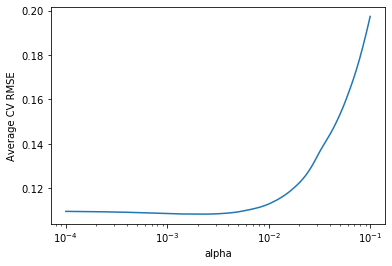

In [6]:
lasso_gs = GridSearchCV(
    Lasso(max_iter=10000),
    {'alpha':np.logspace(-4,-1, 400)},
    'neg_mean_squared_error',
    n_jobs=4,
    cv=5,
)
best_lasso = lasso_gs.fit(X_train, y_train)
lasso_cv_scores = pd.DataFrame(best_lasso.cv_results_)

print("Best param:",best_lasso.best_params_)
print("Best MSE:",best_lasso.best_score_)
print("Best RMSE:",np.sqrt(-best_lasso.best_score_))

alpha = lasso_cv_scores.param_alpha.values
cv_score = lasso_cv_scores.mean_test_score.values

plt.yscale("linear")
plt.xscale("log")
plt.plot(alpha, np.sqrt(-cv_score))
plt.xlabel("alpha")
plt.ylabel("Average CV RMSE");

In [7]:
feat_names = house_pipe.named_steps['feat_names'].feat_names
lasso_coefs = sorted(list(zip(feat_names, best_lasso.best_estimator_.coef_)), 
               key=lambda x: x[1], 
               reverse=True)
print("{} features chosen by Lasso".format(np.sum(best_lasso.best_estimator_.coef_!=0)))
print([feat[0] for feat in lasso_coefs if feat[1]!=0])

51 features chosen by Lasso
['GrLivArea', 'OverallQual', '1stFlrSF', 'OverallCond', 'TotalBsmtSF', '2ndFlrSF', 'Neighborhood', 'YearBuilt', 'LotArea', 'GarageArea', 'KitchenQual', 'SaleCondition', 'Functional', 'BsmtQual', 'Condition1', 'BsmtExposure', 'MSZoning', 'Fireplaces', 'KitchenAbvGr', 'ExterQual', 'BsmtFinSF1', 'HeatingQC', 'CentralAir', 'BsmtFullBath', 'FireplaceQu', 'GarageYrBlt', 'HalfBath', 'SaleType', 'FullBath', 'GarageCond', 'WoodDeckSF', 'Foundation', 'LotConfig', 'MSSubClass', 'YearRemodAdd', 'RoofStyle', 'MasVnrType', 'GarageFinish', 'OpenPorchSF', 'PoolQC', 'Exterior1st', 'PavedDrive', 'LotFrontage', 'BsmtFinSF2', 'Alley', 'ExterCond', 'Heating', 'LandContour', 'EnclosedPorch', 'MoSold', 'BsmtUnfSF']


<br>
<br

**SFS**

In [8]:
sfs = SFS(LinearRegression(), 
          k_features='parsimonious', 
          forward=True, 
          floating=False,
          verbose=0,
          scoring='neg_mean_squared_error',
          cv=10,
          n_jobs=5
         )

feat_names = house_pipe.named_steps['feat_names'].feat_names
sfs = sfs.fit(X_train, y_train, custom_feature_names=feat_names)

print("{} features chosen by SFS".format(len(sfs.k_feature_names_)))
print("Selected features: {}\n".format(sfs.k_feature_names_))
print("Best score: {}".format(np.sqrt(-sfs.k_score_)))

23 features chosen by SFS
Selected features: ('MSZoning', 'LotArea', 'Neighborhood', 'Condition1', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtQual', 'BsmtExposure', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'KitchenAbvGr', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageYrBlt', 'GarageArea', 'SaleCondition')

Best score: 0.10629260616071375


In [11]:
X_train = sfs.transform(X_train)
X_test = sfs.transform(X_test)

<br>
<br>

## Get submission

In [31]:
# lasso = Lasso(**best_lasso.best_params_, max_iter=10000)
# lasso.fit(train_df, train_labels)
# y_test_pred = lasso.predict(test_df)

lin_regr = LinearRegression()
lin_regr.fit(X_train, y_train)
y_test_pred = lin_regr.predict(X_test)

today = datetime.today()
submission_df = test_id.copy()
submission_df['SalePrice'] = np.exp(y_test_pred)

submission_df.to_csv(f"{today.year}{today.month}{today.day}_attempt3.csv", index=False)

**Submission history**

1.  **0.12556**
2. **0.12226**, drop influential points
3. **0.12232**, (2) & Linear Regression SFS